## Hyperparameter tuning via Optuna

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import pyarrow.parquet as pq
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

sys.path.append("../..")
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
from utils.utils import df_stats

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use


file_path = Path(
    "../../../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_fs_cellprofiler.csv.gz"
)

file_path = Path(
    "../../../../Extracted_Features_(CSV_files)/SHSY5Y_preprocessed_df_sc_norm.parquet"
)

df = pq.read_table(file_path).to_pandas()
# df = pd.read_csv(file_path, engine="pyarrow")

In [3]:
data = Path("../../MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [4]:
# for binary classification testing
df = df.query(
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_DMSO_0.025'| oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_DMSO_0.025'"
)

print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
df_stats(df)

if params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_DMSO_0.025' 'LPS_10.000_DMSO_0.025']
The dimensions of the data are: (52453, 2872)
Number of total missing values across all columns: 104906
Data Subset Is Off


In [5]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['E20' 'I14']
Wells to use for training, validation, and testing ['B14' 'C14' 'B15' 'C15' 'E16' 'E17' 'E21' 'J14' 'I15' 'J15']


In [6]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [7]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

#### Split Data - All Models can proceed through this point

In [8]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    seed=1,
    params=params,
)

In [9]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [10]:
params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", params.IN_FEATURES)
if params.MODEL_TYPE == "Regression":
    params.OUT_FEATURES = 1
else:
    params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", params.OUT_FEATURES)

if params.OUT_FEATURES > 2:
    params.MODEL_TYPE = "Multi_Class"
elif params.OUT_FEATURES == 2:
    params.OUT_FEATURES = params.OUT_FEATURES - 1
    params.MODEL_TYPE = "Binary_Classification"
elif params.OUT_FEATURES == 1:
    params.MODEL_TYPE = "Regression"
else:
    pass
print(params.MODEL_TYPE)

Number of in features:  2847
Number of out features:  2
Binary_Classification


In [11]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [12]:
# no accuracy function must be loss for regression
if params.MODEL_TYPE == "Regression":
    params.METRIC = "loss"
    pass


# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=trial,
    params=params,
    metric=params.METRIC,
    return_info=False,
)


# Study is the object for model optimization
study = optuna.create_study(direction=f"{params.DIRECTION}")
# Here I apply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optimized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=study.best_trial,
    params=params,
    metric=params.METRIC,
    return_info=True,
)

[I 2023-07-06 16:39:17,618] A new study created in memory with name: no-name-aa263156-5336-46e3-88a7-1f57cc4546b0
[I 2023-07-06 16:40:06,070] Trial 0 finished with value: 0.6236558443307877 and parameters: {'n_layers': 1, 'n_units_l0': 4, 'dropout_0': 0.296180798776161, 'learning_rate': 0.08679146229514959, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.6236558443307877.
[I 2023-07-06 16:40:54,652] Trial 1 finished with value: 0.5118416348695756 and parameters: {'n_layers': 2, 'n_units_l0': 5, 'dropout_0': 0.23624389990690237, 'n_units_l1': 10, 'dropout_1': 0.34082032406975843, 'learning_rate': 0.0364589647622932, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.5118416348695756.
[I 2023-07-06 16:41:41,305] Trial 2 finished with value: 0.46535606348514563 and parameters: {'n_layers': 1, 'n_units_l0': 5, 'dropout_0': 0.22975179268900905, 'learning_rate': 0.030391772922786515, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.46535606348514563.
[I 2023-07-06 16:42:28,765]

Validation Accuracy: 78.06812428078251
Validation Loss: 0.45946915209293365
Training Accuracy: 78.03112952413834
Training Loss: 0.46262426703316833


(78.06812428078251,
 0.45946915209293365,
 78.03112952413834,
 0.46262426703316833)

In [13]:
fig = optuna.visualization.plot_optimization_history(study)
graph_path = Path(f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/")
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
graph_path = f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/plot_optimization_history_graph"
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [14]:
fig = optuna.visualization.plot_intermediate_values(study)
graph_path = Path(f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/")
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
graph_path = f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/plot_intermediate_values_graph"
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [15]:
param_dict = extract_best_trial_params(
    study.best_params, params, model_name=params.MODEL_NAME
)

In [16]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    param_dict,
    params,
    params.MODEL_NAME,
)
# get training_metrics
if params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

SGD
Epoch 0: Validation loss decreased (inf --> 0.596320).  Saving model ...
	 Train_Loss: 0.6613 Train_Acc: 56.094 Val_Loss: 0.5963  BEST VAL Loss: 0.5963  Val_Acc: 69.252

Epoch 1: Validation loss decreased (0.596320 --> 0.582041).  Saving model ...
	 Train_Loss: 0.6309 Train_Acc: 66.569 Val_Loss: 0.5820  BEST VAL Loss: 0.5820  Val_Acc: 72.589

Epoch 2: Validation loss decreased (0.582041 --> 0.571000).  Saving model ...
	 Train_Loss: 0.6121 Train_Acc: 71.825 Val_Loss: 0.5710  BEST VAL Loss: 0.5710  Val_Acc: 73.625

Epoch 3: Validation loss decreased (0.571000 --> 0.561942).  Saving model ...
	 Train_Loss: 0.5985 Train_Acc: 72.841 Val_Loss: 0.5619  BEST VAL Loss: 0.5619  Val_Acc: 73.694

Epoch 4: Validation loss decreased (0.561942 --> 0.554239).  Saving model ...
	 Train_Loss: 0.5874 Train_Acc: 73.707 Val_Loss: 0.5542  BEST VAL Loss: 0.5542  Val_Acc: 74.545

Epoch 5: Validation loss decreased (0.554239 --> 0.547432).  Saving model ...
	 Train_Loss: 0.5785 Train_Acc: 73.946 Val_Loss:

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/notebooks/../../MLP_utils/utils.py:953: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/notebooks/../../MLP_utils/utils.py:954: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



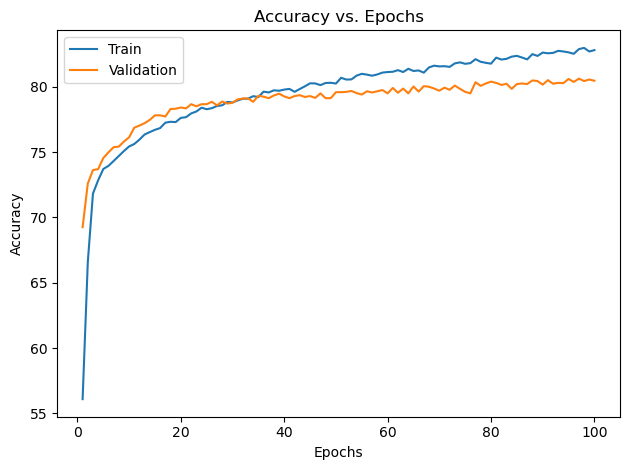

In [17]:
if params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=params.MODEL_NAME,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/notebooks/../../MLP_utils/utils.py:953: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/notebooks/../../MLP_utils/utils.py:954: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



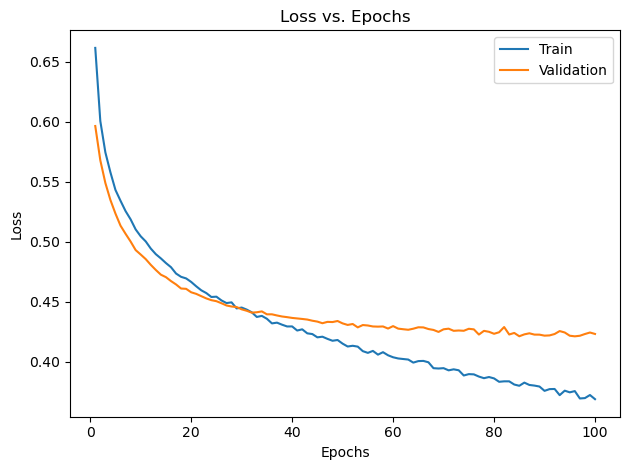

In [18]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=params.MODEL_NAME,
)

In [19]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      3081
           1       0.70      0.55      0.62      1264

    accuracy                           0.80      4345
   macro avg       0.77      0.73      0.74      4345
weighted avg       0.79      0.80      0.80      4345



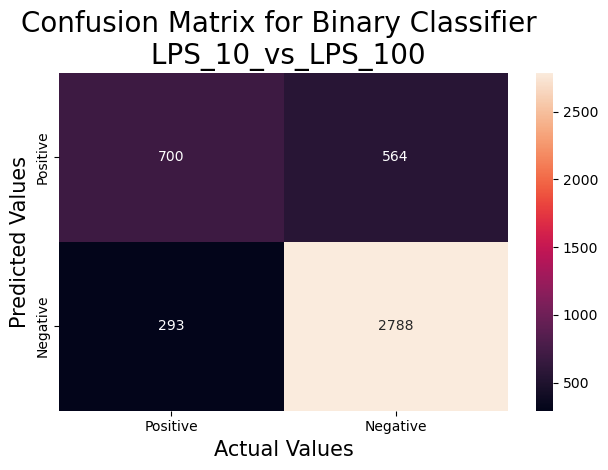

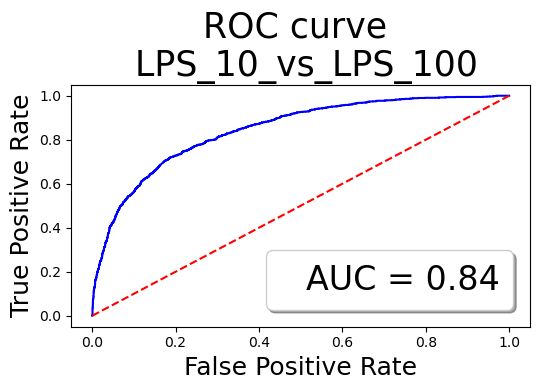

In [20]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{params.MODEL_NAME}_testing",
        model_name=params.MODEL_NAME,
        title=params.MODEL_NAME,
    )
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{params.MODEL_NAME}_testing",
        model_name=params.MODEL_NAME,
        title=params.MODEL_NAME,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

#### look at the feature weights of the model

In [21]:
# get all paramters from pytorch model
lst = []
for name, param in model.named_parameters():
    # print(name, param.shape)
    lst.append(param)
feature_weights = model[0].weight.grad[0].detach().cpu().numpy()

In [22]:
col_list = []
for col in df_values.columns:
    # print(col)
    col_list.append(col)

In [23]:
# remove last 4 columns from col_list that are not features
col_list = col_list[:-4]

In [24]:
pd.set_option("display.max_colwidth", None)

df = pd.DataFrame(zip(col_list, feature_weights), columns=["feature", "weight"])
# change weight collumn to float
df["weight"] = df["weight"].astype(float)
# sort by weight
df = df.sort_values(by=["weight"], ascending=False)
df

feature    weight
2106                             Nuclei_Granularity_8_CorrPM  0.025828
209                           Cytoplasm_Granularity_8_CorrPM  0.024073
1153                              Cells_Granularity_8_CorrPM  0.023759
629   Cytoplasm_RadialDistribution_ZernikePhase_CorrMito_4_0  0.023612
547    Cytoplasm_RadialDistribution_ZernikePhase_CorrDNA_6_4  0.023482
...                                                      ...       ...
2444      Nuclei_RadialDistribution_ZernikePhase_CorrDNA_4_2 -0.023874
976                              Cells_AreaShape_Zernike_4_4 -0.024027
682     Cytoplasm_RadialDistribution_ZernikePhase_CorrPM_9_9 -0.025189
1604      Cells_RadialDistribution_ZernikePhase_CorrMito_9_9 -0.025349
1634        Cells_RadialDistribution_ZernikePhase_CorrPM_9_9 -0.025502

[2847 rows x 2 columns]

In [25]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [26]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

In [27]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [28]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.69      0.85      0.76      4837
           1       0.76      0.55      0.64      4168

    accuracy                           0.71      9005
   macro avg       0.73      0.70      0.70      9005
weighted avg       0.72      0.71      0.71      9005



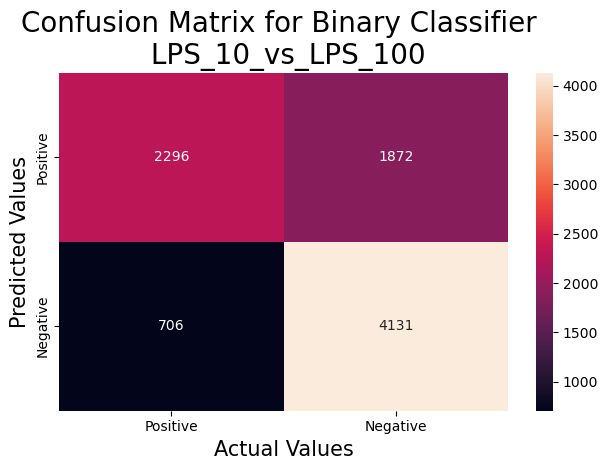

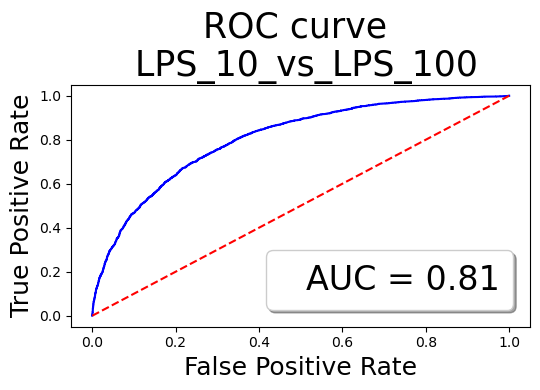

In [29]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(
        y_pred_list,
        df_values_Y,
        params,
        test_name=f"{params.MODEL_NAME}_hold_out",
        model_name=params.MODEL_NAME,
        title=params.MODEL_NAME,
    )
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        df_values_Y,
        params,
        y_pred_prob_list,
        test_name=f"{params.MODEL_NAME}_hold_out",
        model_name=params.MODEL_NAME,
        title=params.MODEL_NAME,
    )
else:
    raise Exception("Model type must be specified for proper model testing")